<a href="https://colab.research.google.com/github/bilalProgTech/mtech-nmims/blob/master/deep-learning/Lab-Work/20220904-Lab-6-MTech-DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#data = pd.read_csv('https://raw.githubusercontent.com/bilalProgTech/online-data-science-ml-challenges/master/Machine-Hack-Grocery-Sales-Forecasting/Train.csv', index_col='Day')
data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv', index_col='Month', parse_dates=True)

#dates = pd.date_range(start='10/1/2020', periods=data.shape[0])
#data.index = dates
data.columns = ['Production']
data.head()

,Production
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [3]:
data.tail()

,Production
Month,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


In [4]:
data.shape

(168, 1)

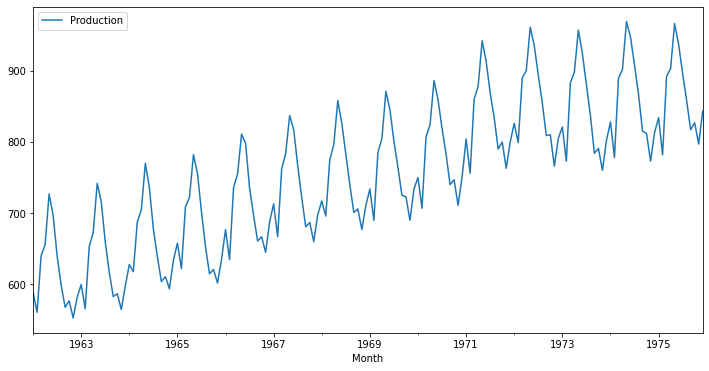

In [5]:
data.plot(figsize=(12,6))
plt.show()

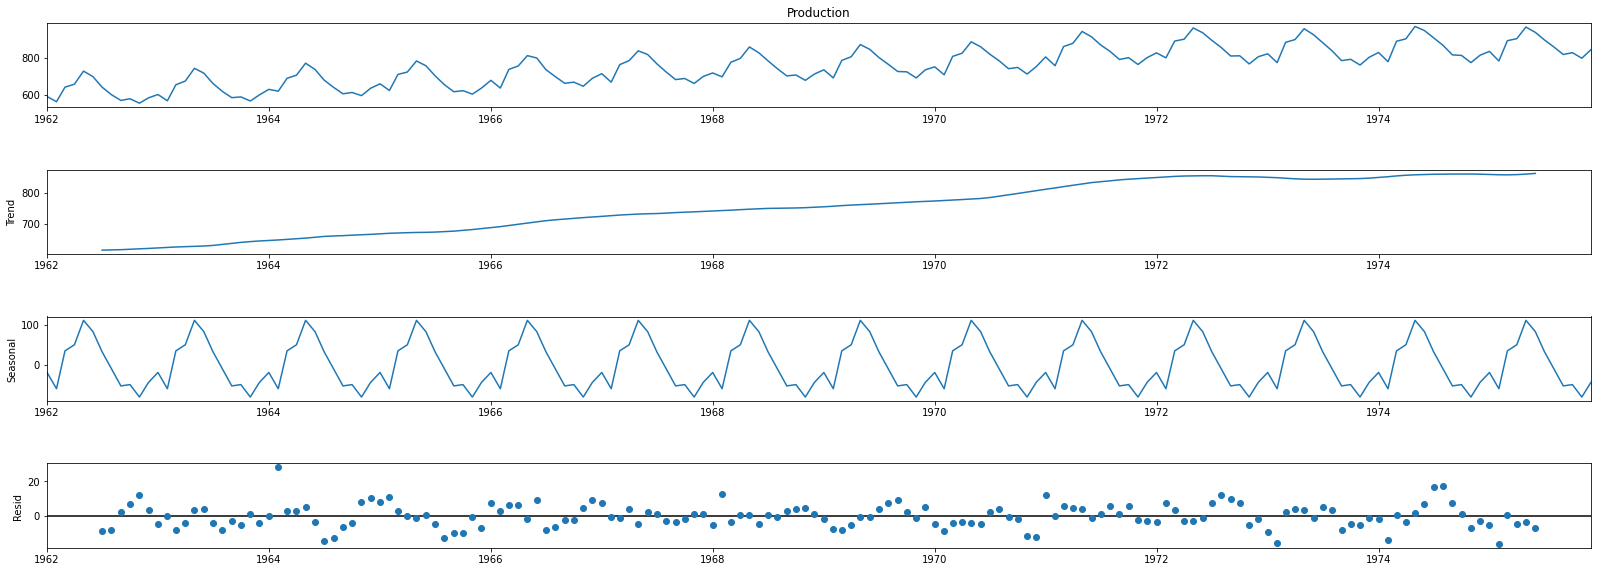

In [6]:
results = seasonal_decompose(data['Production'])
fig = results.plot()
fig.set_size_inches((25, 9))
fig.show()

In [7]:
train = data[:'1974-12-31']
test = data['1975-01-01':]
train.shape, test.shape

((156, 1), (12, 1))

!pip install pmdarima

In [8]:
import pmdarima as pm
arima_model = pm.auto_arima(train['Production'])
print("Best ARIMA Model order for Production: ",arima_model.order)
pred_next = np.round(arima_model.predict(test.shape[0]))

Best ARIMA Model order for Production:  (1, 1, 4)


In [9]:
test['ARIMAPredictionProduction'] = pred_next
test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Production,ARIMAPredictionProduction
Month,,
1975-01-01,834,834.0
1975-02-01,782,854.0
1975-03-01,892,886.0
1975-04-01,903,887.0
1975-05-01,966,889.0


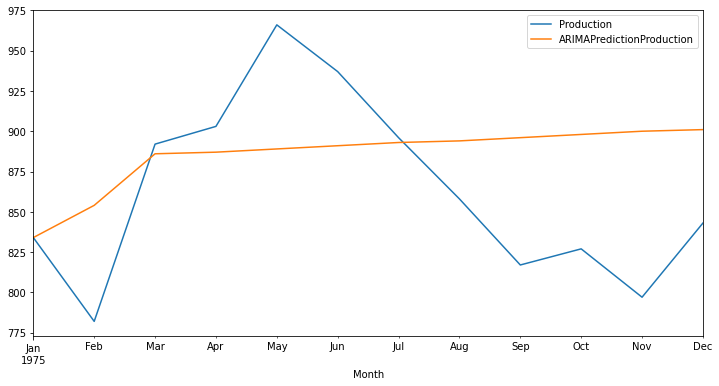

In [10]:
test.plot(figsize=(12,6))
plt.show()

In [11]:
test = test.drop(['ARIMAPredictionProduction'], axis=1)

In [12]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [13]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [15]:
n_days = 12
n_features = train.shape[1]
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=n_days, batch_size=1)

In [16]:
generator[0]

(array([[[0.08653846],
         [0.01923077],
         [0.20913462],
         [0.24759615],
         [0.41826923],
         [0.34615385],
         [0.20913462],
         [0.11057692],
         [0.03605769],
         [0.05769231],
         [0.        ],
         [0.06971154]]]), array([[0.11298077]]))

In [17]:
generator[1]

(array([[[0.01923077],
         [0.20913462],
         [0.24759615],
         [0.41826923],
         [0.34615385],
         [0.20913462],
         [0.11057692],
         [0.03605769],
         [0.05769231],
         [0.        ],
         [0.06971154],
         [0.11298077]]]), array([[0.03125]]))

In [18]:
generator[1][0].shape

(1, 12, 1)

In [19]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_days, n_features)),
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)                          
])
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(generator, epochs=10)

Epoch 1/10
144/144 [==============================] - 6s 14ms/step - loss: 0.0504
Epoch 2/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0311
Epoch 3/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0270
Epoch 4/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0223
Epoch 5/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0191
Epoch 6/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0155
Epoch 7/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0120
Epoch 8/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0109
Epoch 9/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0095
Epoch 10/10
144/144 [==============================] - 2s 14ms/step - loss: 0.0076


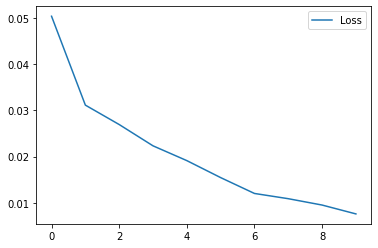

In [21]:
plt.plot(range(10), history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [22]:
temp = scaled_train[-n_days:]
temp = temp.reshape((1, n_days, n_features))
model.predict(temp)

array([[0.72431695]], dtype=float32)

In [23]:
scaled_test[0]

array([0.67548077])

In [24]:
test_predictions = []

last_batch = scaled_train[-n_days:]
current_batch = last_batch.reshape((1, n_days, n_features))

for i in range(len(test)):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]],axis=1)

In [25]:
test['PredictionProduction'] = scaler.inverse_transform(test_predictions)
test.head()

,Production,PredictionProduction
Month,,
1975-01-01,834,854.315853
1975-02-01,782,875.724415
1975-03-01,892,932.598919
1975-04-01,903,971.878712
1975-05-01,966,1005.602421


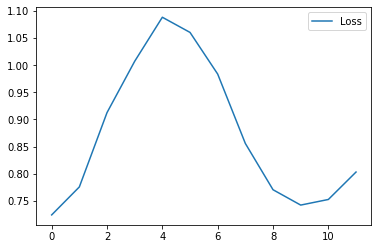

In [26]:
plt.plot(range(len(test)), test_predictions, label='Loss')
plt.legend()
plt.show()

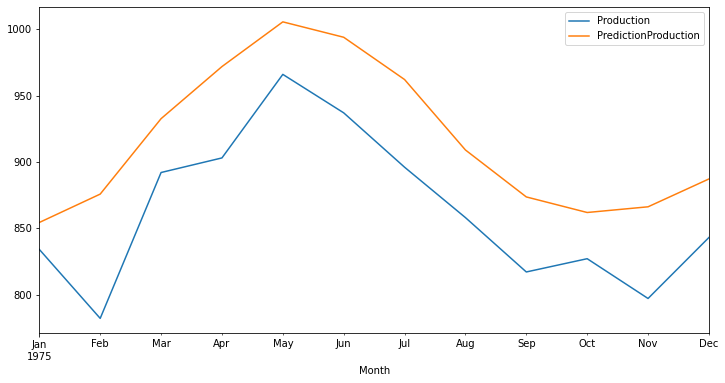

In [27]:
test.plot(figsize=(12,6))
plt.show()

In [28]:
np.sqrt(mean_squared_error(test['Production'],test['PredictionProduction']))

56.658591348361405